# Canal de Keltner para previsão do dólar

Desenvolvido por Chester Keltner nos anos 60 e melhorado por Linda Raschke nos anos 80. É um indicador que usa ATR (Average True Range) e é majoritariamente usado para definir tendencias e volatidades do mercado. Pode ser usado para prever dólar mas geralmente é usado para encontrar pontos de entrada em trading.

### Dependencias

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### Arquivos do dólar

In [20]:
df = pd.read_csv('Dolar.csv', sep=';', decimal=',', encoding='utf-8')
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df = df.sort_values('Data').reset_index(drop=True)

### Average True Range (ATR)
O ATR é a média de amplitude de variação. Um indicador projetado com o intuito de mensurar volatidade.
Ele é o maior valor em meio a três intervalos:
- máxima menos a mínima do período
- a máxima do período menos o fechamento do período anterior
- o fechamento do período anterior menos a mínima atual

O *Average True Range* (ATR) é definido como:

$$
ATR = MME(TR)
$$

onde o *True Range* (TR) é:

$$
TR = \max(H - L,\; H - C_{p},\; C_{p} - L)
$$


In [21]:
def getATR(data, period=14):
    price_change = data['Valor'].diff().abs()
    true_range = price_change.fillna(0)
    
    atr = pd.Series(index=data.index, dtype=float)
    atr.iloc[period-1] = true_range.iloc[:period].mean()
    
    for i in range(period, len(data)):
        atr.iloc[i] = (atr.iloc[i-1] * (period - 1) + true_range.iloc[i]) / period
    
    return atr

### Canal de Keltner

O Canal de Keltner é um indicador técnico que consiste em três linhas paralelas construídas em torno de uma média móvel exponencial (EMA).
Especialmente útil para identificar condições extremas do mercado e medir a volatilidade atual, auxiliando na definição de estratégias de entrada e saída em operações de trading.

#### Componentes do Canal

1. **Linha Média (EMA)**: Média móvel exponencial dos preços, que serve como referência central do canal.

2. **Banda Superior**: Calculada como EMA + (ATR × multiplicador), representando o limite superior de volatilidade.

3. **Banda Inferior**: Calculada como EMA - (ATR × multiplicador), representando o limite inferior de volatilidade.

O multiplicador típico é 2, mas pode ser ajustado conforme a necessidade de sensibilidade do indicador.

#### Como Funciona

O canal adapta-se dinamicamente à volatilidade do mercado através do ATR. Em períodos de alta volatilidade, o canal se expande, e em períodos de baixa volatilidade, o canal se contrai.

Quando os preços tocam ou ultrapassam as bandas, isso pode indicar condições de sobrecompra ou sobrevenda, dependendo do contexto do mercado.

In [22]:
def getKeltnerChannel(data, ema_period=20, atr_period=14, multiplier=2):
    data['EMA'] = data['Valor'].ewm(span=ema_period).mean()
    atr = getATR(data, atr_period)
    data['KC_Upper'] = data['EMA'] + (atr * multiplier)
    data['KC_Lower'] = data['EMA'] - (atr * multiplier)
    return data



In [23]:
df = getKeltnerChannel(df)

df['Previsao'] = np.where(
    df['Valor'] > df['KC_Upper'],
    df['EMA'] - (df['Valor'] - df['KC_Upper']),
    np.where(
        df['Valor'] < df['KC_Lower'],
        df['EMA'] + (df['KC_Lower'] - df['Valor']),
        df['Valor']
    )
)

split_date = df['Data'].max() - timedelta(days=30)
train_data = df[df['Data'] <= split_date]
test_data = df[df['Data'] > split_date]

### Conclusão

O Canal de Keltner apresenta limitações significativas quando aplicado para previsão de preços do dólar.


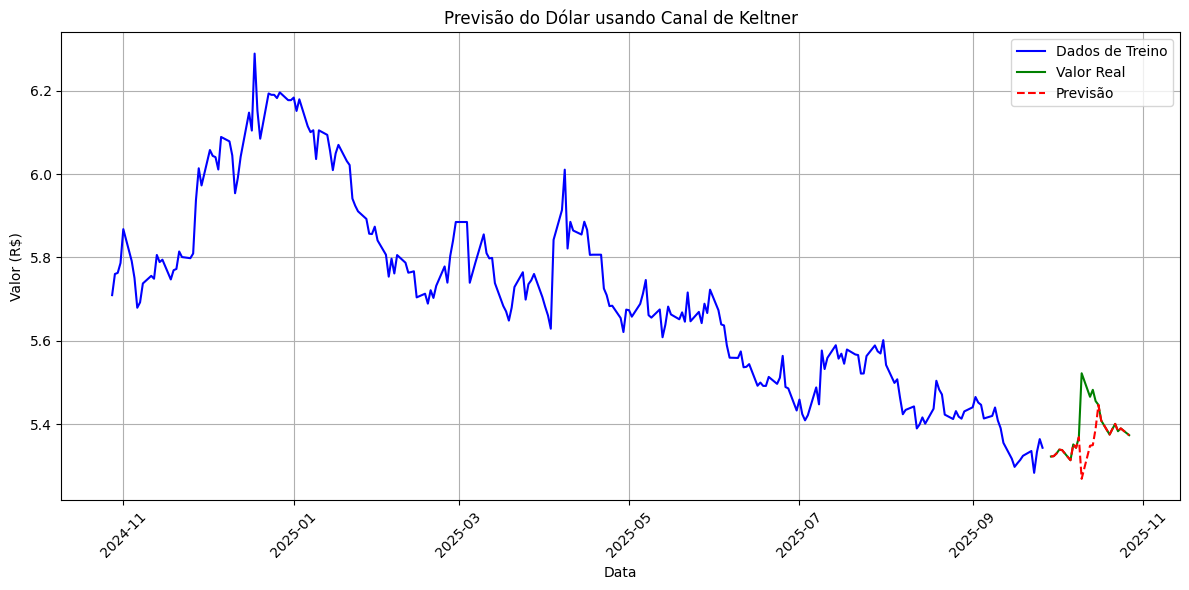

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Data'], train_data['Valor'], label='Dados de Treino', color='blue')
plt.plot(test_data['Data'], test_data['Valor'], label='Valor Real', color='green')
plt.plot(test_data['Data'], test_data['Previsao'], label='Previsão', color='red', linestyle='--')
plt.title('Previsão do Dólar usando Canal de Keltner')
plt.xlabel('Data')
plt.ylabel('Valor (R$)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




#### Limitações do Modelo

O indicador depende de várias variáveis e condições de mercado que podem não ser completamente capturadas apenas pelos dados históricos de preço.

Ele funciona melhor como ferramenta de análise técnica em trading de curto prazo, onde a volatilidade tem menor influência e o foco está em identificar oportunidades de entrada e saída.

#### Aplicações Práticas

Para trading de curto prazo, o Canal de Keltner é mais eficaz quando combinado com outros indicadores técnicos e análise fundamentalista.

A identificação de reversões e tendências funciona melhor em mercados com padrões de comportamento mais previsíveis e maior liquidez.

#### Análise dos Resultados

Os resultados obtidos mostram que o modelo consegue capturar parte do comportamento do preço, mas apresenta erros significativos que tornam suas previsões pouco confiáveis para tomada de decisões financeiras.

O RMSE de aproximadamente 0.069 e MAE de 0.027 indicam que as previsões podem desviar significativamente dos valores reais, especialmente em períodos de alta volatilidade.

#### Considerações Finais

A previsão de preços de moedas é complexa e depende de fatores macroeconômicos, políticos, geopolíticos e de mercado que não são capturados por indicadores técnicos puros.

O Canal de Keltner é uma ferramenta útil para análise técnica, mas deve ser usada como parte de uma estratégia mais ampla, combinada com outros indicadores e análise fundamentalista, não como única fonte de decisão.

### Refêrencias

- https://chartschool-stockcharts-com.translate.goog/table-of-contents/technical-indicators-and-overlays/technical-overlays/keltner-channels?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc&_x_tr_hist=true

- https://www.modalmais.com.br/blog/indicador-atr/